# 3D Dance Rendering

In [1]:
!ls /root/dev/DanceGen/MambaDance

config	 eval	main.py  requirements.txt  tmp	     util
dataset  jjuke	model	 script		   train.py  wandb


In [2]:
import os

os.chdir("/root/dev/DanceGen/MambaDance")
os.getcwd()

'/root/dev/DanceGen/MambaDance'

In [3]:
import torch

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.current_device()

0

In [4]:
!gpustat

02a80a123138                Tue Feb 25 17:49:17 2025  550.142
[0] NVIDIA GeForce RTX 4090 | 36°C,   0 % |   892 / 24564 MB |


# Libraries

In [27]:
import pickle
from pathlib import Path

import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import librosa as lr
import soundfile as sf
from einops import rearrange
from matplotlib import cm
from matplotlib.colors import ListedColormap

from dataset import GENRES_AIST, GENRES_FINEDANCE
from util.render_joints.smplfk import SMPLSkeleton, SMPLX_Skeleton, SMPL_PARENTS, SMPLX_PARENTS
from util.smpl_to_fbx.FbxReadWriter import FbxReadWrite
from util.vis import plot_single_pose

smpl_model = SMPLSkeleton(device=device)
smplx_model = SMPLX_Skeleton(joint_path="/root/dev/DanceGen/MambaDance/util/render_joints/smplx_neu_J_1.npy", device=device)

# AIST++ Rendering

In [5]:
!ls /root/dataset_sj/DanceGen/exp/MambaDance2/AIST/250221_2037_MambaDance2_naive_bs512_nssm2_dstate64_dhead32/res_epoch1600/long_unnormalized/motions

gBR_sBM_cAll_d04_mBR0_ch02.pkl	gLH_sBM_cAll_d17_mLH4_ch02.pkl
gBR_sBM_cAll_d05_mBR0_ch02.pkl	gLH_sBM_cAll_d18_mLH4_ch02.pkl
gHO_sBM_cAll_d20_mHO5_ch02.pkl	gLO_sBM_cAll_d13_mLO2_ch02.pkl
gHO_sBM_cAll_d21_mHO5_ch02.pkl	gLO_sBM_cAll_d15_mLO2_ch02.pkl
gJB_sBM_cAll_d08_mJB5_ch02.pkl	gMH_sBM_cAll_d22_mMH3_ch02.pkl
gJB_sBM_cAll_d09_mJB5_ch02.pkl	gMH_sBM_cAll_d24_mMH3_ch02.pkl
gJS_sBM_cAll_d01_mJS3_ch02.pkl	gPO_sBM_cAll_d10_mPO1_ch02.pkl
gJS_sBM_cAll_d03_mJS3_ch02.pkl	gPO_sBM_cAll_d11_mPO1_ch02.pkl
gKR_sBM_cAll_d28_mKR2_ch02.pkl	gWA_sBM_cAll_d25_mWA0_ch02.pkl
gKR_sBM_cAll_d30_mKR2_ch02.pkl	gWA_sBM_cAll_d26_mWA0_ch02.pkl


In [215]:
motion_dir = Path("/root/dataset_sj/DanceGen/exp/MambaDance2/AIST/250221_2037_MambaDance2_naive_bs512_nssm2_dstate64_dhead32/res_epoch1600/long_unnormalized/motions/")
wav_name = "gLH_sBM_cAll_d17_mLH4_ch02.pkl"

with (motion_dir / wav_name).open("rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['smpl_poses', 'smpl_trans', 'full_pose'])

In [230]:
pos, q = torch.tensor(data["smpl_trans"]).to(device), torch.tensor(data["smpl_poses"]).to(device)
print(pos.shape)
print(q.shape)

torch.Size([225, 3])
torch.Size([225, 72])


In [231]:
new_pos, new_q = pos, rearrange(q, "n (j d) -> n j d", j=24)
pose = smpl_model.forward(new_q.unsqueeze(0), new_pos.unsqueeze(0)).detach().cpu().numpy()[0]
print(pose.shape)

(225, 24, 3)


[[0.04235019 0.04185107 0.05604503 0.0741353 ]
 [0.0147253  0.02316403 0.04160758 0.02497875]
 [0.01283124 0.0063488  0.0111034  0.01034188]
 ...
 [0.0058342  0.00546145 0.00594407 0.00480779]
 [0.00577973 0.00602185 0.00564552 0.00545326]
 [0.         0.         0.         0.        ]]


/tmp/ipykernel_3189934/4217823479.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = [ax.scatter([], [], [], zorder=10, s=0, cmap=ListedColormap(["r", "g", "b"])) for _ in range(4)]


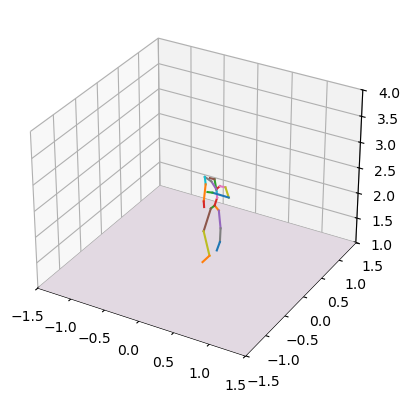

In [232]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

point = np.array([0, 0, 1])
normal = np.array([0, 0, 1])
d = -point.dot(normal)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 2), np.linspace(-1.5, 1.5, 2))
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

ax.plot_surface(xx, yy, z, zorder=-11, cmap=cm.twilight)

smpl_parents = SMPL_PARENTS

lines = [ax.plot([], [], [], zorder=10, linewidth=1.5)[0] for _ in smpl_parents]
scat = [ax.scatter([], [], [], zorder=10, s=0, cmap=ListedColormap(["r", "g", "b"])) for _ in range(4)]
axrange = 3

smpl_type = "smpl"

# feet = pose[None, (7, 8, 10, 11)]
# feetv = np.zeros(feet.shape[:2])
# feetv[:-1] = np.linalg.norm(feet[1:] - feet[:-1], axis=-1)
contact = feetv < 0.01
print(feetv)

anim = animation.FuncAnimation(fig, plot_single_pose, pose.shape[0], fargs=(pose, lines, ax, axrange, scat, contact, smpl_type), interval=1000 // 30)

# FineDance Rendering

In [38]:
!ls /root/dataset_sj/DanceGen/exp/MambaDance2/FineDance/250221_1931_MambaDance2_naive_nssm1_dstate64_dhead32_seqlen1024/res/renders/practice

012.pkl  063.pkl  098.pkl  132.pkl  144.pkl  193.pkl  211.pkl
036.pkl  065.pkl  109.pkl  137.pkl  161.pkl  198.pkl
037.pkl  092.pkl  130.pkl  143.pkl  179.pkl  204.pkl


In [233]:
motion_dir = Path("/root/dataset_sj/DanceGen/exp/MambaDance2/FineDance/250221_1931_MambaDance2_naive_nssm1_dstate64_dhead32_seqlen1024/res/renders/practice")
wav_name = "037.pkl"

with (motion_dir / wav_name).open("rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['smpl_poses', 'smpl_trans', 'full_q', 'full_pos', 'sample_contact'])

In [262]:
from pytorch3d.transforms import RotateAxisAngle, axis_angle_to_quaternion, quaternion_multiply, quaternion_to_axis_angle

def rotate_smpl(q, pos, angle, axis, device="cuda"):
    """
    Rotates the SMPL parameters by a given angle along a specified axis.

    Args:
        q (torch.Tensor): Joint rotations in axis-angle representation (N, J, 3).
        pos (torch.Tensor): Joint positions (N, 3).
        angle (float): Rotation angle in degrees.
        axis (str): Rotation axis ("X", "Y", or "Z").
        device (str): Device to use.
    """
    axis = axis.upper()
    assert len(q.shape) == 3 and len(pos.shape) == 2
    assert axis in ["X", "Y", "Z"]
    
    q_ = q[:, :1, :] # global rotation -> (N, 1, 3)
    q_quat = axis_angle_to_quaternion(q_) # (N, 1, 4)
    
    # rot_quat = RotateAxisAngle(angle, axis=axis, degrees=True, device=device).get_matrix() # (3, 3)
    rot_angle = torch.tensor([[np.deg2rad(angle), 0, 0] if axis == "X" else
                           [0, np.deg2rad(angle), 0] if axis == "Y" else
                           [0, 0, np.deg2rad(angle)]], device=device, dtype=torch.float32)
    rot_quat = axis_angle_to_quaternion(rot_angle) # (1, 4)
    
    q_quat = quaternion_multiply(rot_quat, q_quat) # (N, 1, 4)
    q_ = quaternion_to_axis_angle(q_quat) # (N, 1, 3)
    q[:, :1, :] = q_
    
    pos_rotation = RotateAxisAngle(angle, axis=axis, degrees=True, device=device)
    pos = pos_rotation.transform_points(pos) # (y, z) -> (-z, y)
    
    return q, pos

In [269]:
pos, q = torch.tensor(data["full_pos"]).to(device), torch.tensor(data["full_q"]).to(device)
print(pos.shape)
print(q.shape)

torch.Size([2560, 3])
torch.Size([2560, 66])


In [270]:
new_pos, new_q = pos, rearrange(q, "n (j d) -> n j d", j=22)

new_q, new_pos = rotate_smpl(new_q, new_pos, 90, "X", device=device)
new_q, new_pos = rotate_smpl(new_q, new_pos, 0, "Y", device=device)
new_q, new_pos = rotate_smpl(new_q, new_pos, 0, "Z", device=device)

N = new_q.shape[0]
hand = torch.zeros([N, 30, 3]).to(device)
new_q = rearrange(torch.cat([new_q, hand], dim=1), "n j d -> n (j d)") # d = (22+30)*3 = 156
full_pose = smplx_model.forward(new_q, new_pos).detach().cpu().numpy()
print(full_pose.shape)

(2560, 55, 3)


/tmp/ipykernel_3189934/1425978367.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = [ax.scatter([], [], [], zorder=10, s=0, cmap=ListedColormap(["r", "g", "b"])) for _ in range(4)]


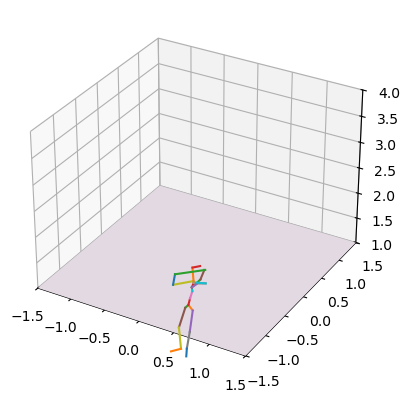

In [271]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

point = np.array([0, 0, 1])
normal = np.array([0, 0, 1])
d = -point.dot(normal)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 2), np.linspace(-1.5, 1.5, 2))
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

ax.plot_surface(xx, yy, z, zorder=-11, cmap=cm.twilight)

smpl_parents = SMPLX_PARENTS

lines = [ax.plot([], [], [], zorder=10, linewidth=1.5)[0] for _ in smpl_parents]
scat = [ax.scatter([], [], [], zorder=10, s=0, cmap=ListedColormap(["r", "g", "b"])) for _ in range(4)]
axrange = 3

smpl_type = "smpl"

feet = full_pose[:, (7, 8, 10, 11)]
feetv = np.zeros(feet.shape[:2])
feetv[:-1] = np.linalg.norm(feet[1:] - feet[:-1], axis=-1)
contact = feetv < 0.01
# print(contact[:20])

anim = animation.FuncAnimation(fig, plot_single_pose, full_pose.shape[0], fargs=(full_pose, lines, ax, axrange, scat, contact, smpl_type), interval=1000 // 30)

# FBX rendering

In [242]:
from fbx import (FbxAnimCurve, FbxTime, FbxAnimCurveDef,
                 FbxAnimStack, FbxAnimLayer, FbxCriteria)
from FbxCommon import LoadScene, SaveScene, InitializeSdkObjects

lSdkManager, lScene = InitializeSdkObjects()
lResult = LoadScene(lSdkManager, lScene, "/root/dev/DanceGen/MambaDance/util/smpl_to_fbx/ybot.fbx")
print(lResult)

True


In [256]:
def print_hierarchy(node=None, depth=0):
    if node is None:
        node = lScene.GetRootNode()
        if not node:
            print("No root node found.")
            return
    
    print("  " * depth + f"- {node.GetName()}")
    
    for i in range(node.GetChildCount()):
        print_hierarchy(node.GetChild(i), depth + 1)

In [257]:
lRootNode = lScene.GetRootNode()

print_hierarchy()

- RootNode
  - Alpha_Joints.003
  - Alpha_Surface.003
  - smpl
    - m_avg_Pelvis
      - m_avg_L_Hip
        - m_avg_L_Knee
          - m_avg_L_Ankle
            - m_avg_L_Foot
              - m_avg_L_Foot_end
      - m_avg_R_Hip
        - m_avg_R_Knee
          - m_avg_R_Ankle
            - m_avg_R_Foot
              - m_avg_R_Foot_end
      - m_avg_Spine1
        - m_avg_Spine2
          - m_avg_Spine3
            - m_avg_Neck
              - m_avg_Head
                - m_avg_Head_end
            - m_avg_L_Collar
              - m_avg_L_Shoulder
                - m_avg_L_Elbow
                  - m_avg_L_Wrist
                    - m_avg_L_Hand
                      - m_avg_L_Hand_end
            - m_avg_R_Collar
              - m_avg_R_Shoulder
                - m_avg_R_Elbow
                  - m_avg_R_Wrist
                    - m_avg_R_Hand
                      - m_avg_R_Hand_end
  - Alpha_Surface.005
  - Alpha_Surface.006
  - Alpha_Surface.007
  - Alpha_Surface.008
  - Alpha_